<a href="https://colab.research.google.com/github/andresvosa/testNotebooks/blob/main/time_series_fbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Installation if needed
#!pip install pystan
#!pip install fbprophet

In [2]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt


Extracting and processing the data from csv file

In [3]:

data = []
tab_len = 12
year_rows = [9, 25, 41]
for cnt, ele in enumerate(year_rows):
  year_data = pd.read_csv('/content/tarbimine.csv', skiprows=ele, nrows=tab_len, sep=';', decimal=',')
  year_data.columns.values[0] = 'Month'
  year_data['Year'] = f'202{cnt}'
  year_data['Month_No'] = year_data.reset_index().index + 1
  year_data['Date'] = pd.to_datetime(year_data.Year.astype(str)+ '-' + year_data.Month_No.astype(str)) + MonthEnd(0)
  data.append(year_data)
  #display(year_data)
#consumption = pd.concat(data, axis=0)
consumption = pd.concat([data[0], data[1]], axis=0)
consumption.drop(['Month', 'Year', 'Month_No'], axis=1, inplace=True)
consumption.dropna(inplace=True)
consumption.set_index('Date', inplace=True, verify_integrity=True)
display(consumption)

,Päev (kWh),Öö (kWh),Kokku (kWh)
Date,,,
2020-01-31,436.410,458.897,895.307
2020-02-29,451.744,496.671,948.415
2020-03-31,445.112,529.966,975.078
2020-04-30,407.123,454.009,861.132
2020-05-31,349.422,378.125,727.547
2020-06-30,226.309,175.161,401.470
2020-07-31,228.542,164.714,393.256
2020-08-31,186.975,181.973,368.948
2020-09-30,173.869,200.843,374.712


Plot prepeared data for visualizing

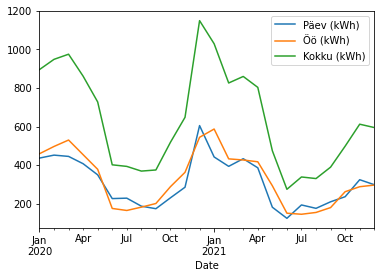

In [4]:
consumption.plot()

Model dataset

In [5]:
selector_d = {'Date': 'ds', 'Kokku (kWh)': 'y'}
votmed = list(selector_d.keys())
trainingset = consumption.filter(['Date', 'Kokku (kWh)'], axis=1)
trainingset.reset_index(inplace=True)
trainingset.rename(columns=selector_d, inplace=True)
display(trainingset)
print(trainingset.columns)

,ds,y
0,2020-01-31,895.307
1,2020-02-29,948.415
2,2020-03-31,975.078
3,2020-04-30,861.132
4,2020-05-31,727.547
5,2020-06-30,401.470
6,2020-07-31,393.256
7,2020-08-31,368.948
8,2020-09-30,374.712
9,2020-10-31,518.485


Index(['ds', 'y'], dtype='object')


In [6]:
#dir(Prophet)
help(Prophet.fit)

Help on function fit in module fbprophet.forecaster:

fit(self, df, **kwargs)
    Fit the Prophet model.
    
    This sets self.params to contain the fitted model parameters. It is a
    dictionary parameter names as keys and the following items:
        k (Mx1 array): M posterior samples of the initial slope.
        m (Mx1 array): The initial intercept.
        delta (MxN array): The slope change at each of N changepoints.
        beta (MxK matrix): Coefficients for K seasonality features.
        sigma_obs (Mx1 array): Noise level.
    Note that M=1 if MAP estimation.
    
    Parameters
    ----------
    df: pd.DataFrame containing the history. Must have columns ds (date
        type) and y, the time series. If self.growth is 'logistic', then
        df must also have a column cap that specifies the capacity at
        each ds.
    kwargs: Additional arguments passed to the optimizing or sampling
        functions in Stan.
    
    Returns
    -------
    The fitted Prophet objec

Model operations

In [7]:
# Initialize the model
#model = Prophet()
model = Prophet(yearly_seasonality=True)
# Train the model
model.fit(trainingset)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


In [8]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [9]:
# Predict future consumption for 12 month
future_dates = model.make_future_dataframe(periods=12, freq='M')
display(future_dates.tail())

,ds
31,2022-08-31
32,2022-09-30
33,2022-10-31
34,2022-11-30
35,2022-12-31


In [10]:
prediction = model.predict(future_dates)
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-31,628.881489,869.466553,963.800198,628.881489,628.881489,289.686466,289.686466,289.686466,289.686466,289.686466,289.686466,0.0,0.0,0.0,918.567956
1,2020-02-29,618.946205,832.956846,929.029412,618.946205,618.946205,262.184442,262.184442,262.184442,262.184442,262.184442,262.184442,0.0,0.0,0.0,881.130647
2,2020-03-31,608.325729,885.546371,977.568158,608.325729,608.325729,322.568551,322.568551,322.568551,322.568551,322.568551,322.568551,0.0,0.0,0.0,930.894280
3,2020-04-30,598.047849,797.339574,891.671811,598.047849,598.047849,246.393618,246.393618,246.393618,246.393618,246.393618,246.393618,0.0,0.0,0.0,844.441466
4,2020-05-31,587.427372,689.443294,787.790722,587.427372,587.427372,152.429937,152.429937,152.429937,152.429937,152.429937,152.429937,0.0,0.0,0.0,739.857310


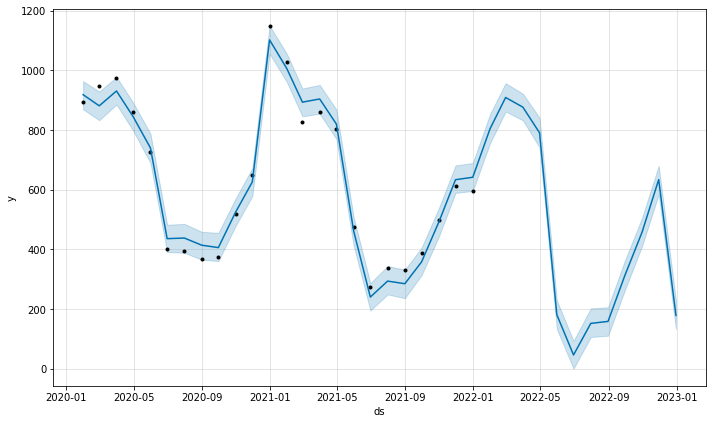

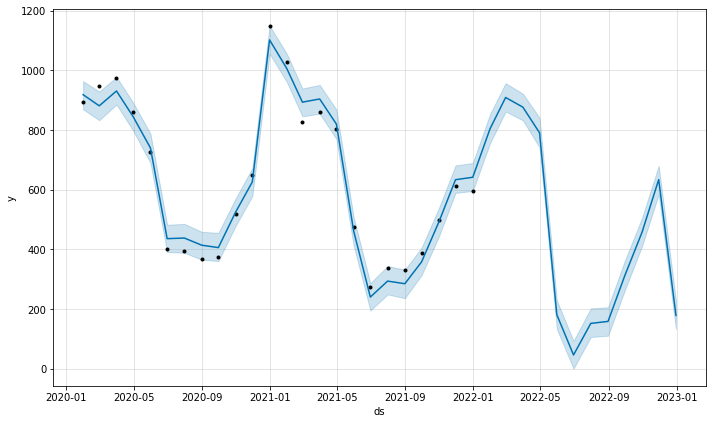

In [11]:
# Plot the predicted projection
model.plot(prediction)


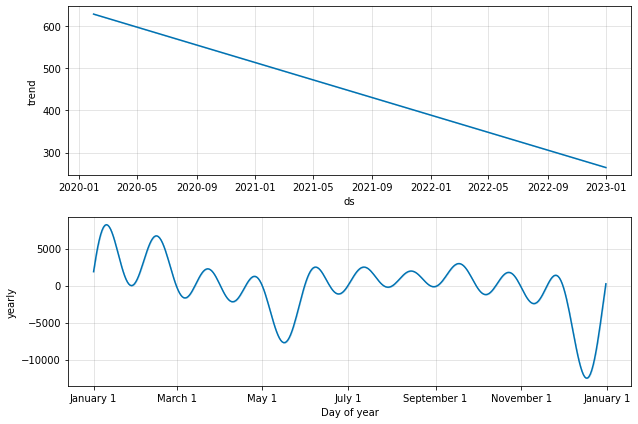

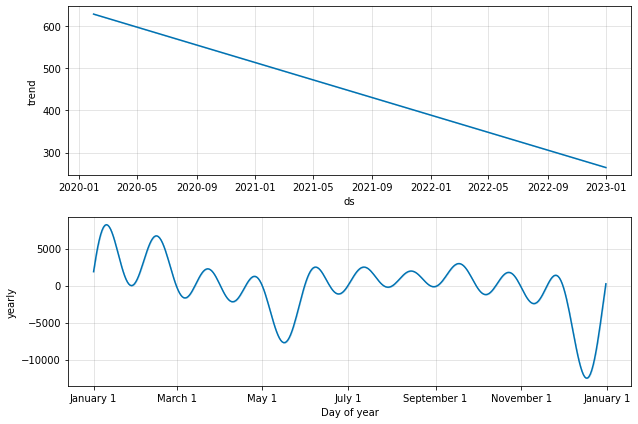

In [12]:
model.plot_components(prediction)

In [13]:
#df_crossvalid = cross_validation(model, initial='42 M', period='6 M', horizon='12 M')
df_crossvalid = cross_validation(model, period='6 M', horizon='12 M')
df_crossvalid.head()

INFO:fbprophet:Making 12 forecasts with cutoffs between 2021-01-30 23:48:00 and 2021-12-30 23:48:00


  0%|          | 0/12 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-31,-6434.531435,-6438.191989,-6430.531813,1029.276,2021-01-30 23:48:00
1,2021-02-28,-1145.216238,-1146.592557,-1143.809778,825.847,2021-02-27 23:48:00
2,2021-03-31,-942.447351,-952.386032,-931.044068,859.718,2021-03-30 23:48:00
3,2021-04-30,572.495581,571.301434,574.162173,803.043,2021-04-29 23:48:00
4,2021-05-31,621.156167,602.937841,639.314272,474.349,2021-05-30 23:48:00


In [14]:
df_perform = performance_metrics(df_crossvalid)
df_perform.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 00:12:00,5.712347e+06,2390.05164,1301.989458,1.700429,0.84719,0.0
